In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.smpickle import load_pickle

import comp_utils
import xgboost as xgb 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle as pkl

# Data

## Wind

In [2]:
# already localized at Hornsea (6 lat/long pairs)
dwd_Hornsea1 = xr.open_dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")

df_h1_feats = dwd_Hornsea1.mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
df_h1_feats["ref_datetime"] = df_h1_feats["ref_datetime"].dt.tz_localize("UTC")
df_h1_feats["valid_datetime"] = df_h1_feats["ref_datetime"] + pd.TimedeltaIndex(df_h1_feats["valid_datetime"],unit="hours")

In [3]:
import re

def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

df_h1_feats.columns = [camel_to_snake(col) for col in df_h1_feats.columns]

# rename wind_direction:100	
df_h1_feats.rename(columns={"wind_direction:100":"wind_direction_100"},inplace=True)
df_h1_feats.rename(columns={"wind_speed:100":"wind_speed_100"},inplace=True)

df_h1_feats

,ref_datetime,valid_datetime,relative_humidity,temperature,wind_direction,wind_direction_100,wind_speed,wind_speed_100
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,85.213753,15.416670,61.588081,62.085171,10.043627,11.802604
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,84.810783,15.408349,60.819256,61.368782,9.767446,11.495032
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,83.904999,15.494086,60.202793,60.853313,9.494630,11.213223
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,82.977669,15.459883,56.277557,57.054363,9.455198,11.135883
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,82.238251,15.506005,54.625359,55.247116,9.515404,11.254492
...,...,...,...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,85.169495,12.467031,258.679993,258.742950,3.495213,3.701586
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,86.336761,12.294271,288.635559,288.763794,6.475207,7.006474
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,80.832611,12.715936,290.076538,290.225403,5.601550,6.105711
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,80.463524,12.888119,267.246643,267.324860,6.097645,6.729563


## Solar 

In [255]:
dwd_solar = xr.open_dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
df_solar_feats = dwd_solar.mean(dim="point").to_dataframe().reset_index()
df_solar_feats["ref_datetime"] = df_solar_feats["ref_datetime"].dt.tz_localize("UTC")
df_solar_feats["valid_datetime"] = df_solar_feats["ref_datetime"] + pd.TimedeltaIndex(df_solar_feats["valid_datetime"],unit="hours")

# change to snake case
df_solar_feats.columns = [camel_to_snake(col) for col in df_solar_feats.columns]

In [254]:
df_solar_feats

,ref_datetime,valid_datetime,cloud_cover,solar_downward_radiation,temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.450405,0.000000,13.646173
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.494018,0.000000,13.670843
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.546410,0.000000,13.793360
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,0.627071,0.000000,13.907354
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,0.681062,0.000000,14.022113
...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,0.810468,180.746119,12.455963
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,0.459340,23.697193,12.856787
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,0.069910,0.976647,10.006506
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,0.652018,0.932845,8.682965


## Energy 

In [4]:
df_energy = pd.read_csv("data/Energy_Data_20200920_20231027.csv")
df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])
df_energy["Wind_MWh_credit"] = 0.5*df_energy["Wind_MW"] - df_energy["boa_MWh"]
df_energy["Solar_MWh_credit"] = 0.5*df_energy["Solar_MW"]

In [5]:
# lower case all col headers
df_energy.columns = [col.lower() for col in df_energy.columns]

## Features prep

In [199]:
# merge wind and energy data

# group by reference time (forecasts provided hourly), resample to 30 minutes, interpolate linearly
df_modelling = df_h1_feats.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
df_modelling = df_modelling.drop(columns="ref_datetime",axis=1).reset_index()

# merge in energy data
df_modelling = df_modelling.merge(df_energy,how="inner",left_on="valid_datetime",right_on="dtm")

# drop weather predictions that are more than 50h ahead 
df_modelling = df_modelling[df_modelling["valid_datetime"] - df_modelling["ref_datetime"] < np.timedelta64(50,"h")]

# add delta hours 
df_modelling['delta_hours_forecast'] = (df_modelling.valid_datetime - df_modelling.ref_datetime) / np.timedelta64(1, 'h')

# since wind dir seems to have some predictive power
# get sin and cos from wind direction and wind direction 100
df_modelling["wind_direction_sin"] = np.sin(df_modelling["wind_direction"]*np.pi/180)
df_modelling["wind_direction_cos"] = np.cos(df_modelling["wind_direction"]*np.pi/180)
df_modelling["wind_direction_100_sin"] = np.sin(df_modelling["wind_direction_100"]*np.pi/180)
df_modelling["wind_direction_100_cos"] = np.cos(df_modelling["wind_direction_100"]*np.pi/180)

# sort the data by ref_datetime and valid_datetime
df_modelling.sort_values(["ref_datetime","valid_datetime"],inplace=True)

# wind dir will matter if the nacelle is off vs wind, which might happen if the wind is changing direction a lot
# so get the diff in wind direction bw timestamps
wind_dir_diffs = df_modelling.groupby(df_modelling.ref_datetime)[
    ['wind_direction_sin','wind_direction_cos','wind_direction_100_sin','wind_direction_100_cos']].diff(1)
wind_dir_diffs.columns = [col + "_diff" for col in wind_dir_diffs.columns]
df_modelling = pd.concat([df_modelling,wind_dir_diffs],axis=1)
# also get rolling std on the wind dir for the same reasons
wind_dir_roll_std = df_modelling.groupby(df_modelling.ref_datetime)[
    ['wind_direction_sin','wind_direction_cos','wind_direction_100_sin','wind_direction_100_cos']].rolling(4).std()
wind_dir_roll_std.columns = [col + "_roll_std" for col in wind_dir_roll_std.columns]
df_modelling = pd.concat([df_modelling,wind_dir_roll_std.droplevel(0)],axis=1)

# get the revision in forecast bw different ref datetimes - only for wind speed which is the most important
wind_speed_rev = df_modelling.groupby(df_modelling.valid_datetime)[['wind_speed','wind_speed_100']].diff(1)
wind_speed_rev.columns = [col + "_rev_diff" for col in wind_speed_rev.columns]
df_modelling = pd.concat([df_modelling,wind_speed_rev],axis=1)
# and the std in the forecasts
wind_speed_roll_std = df_modelling.groupby(df_modelling.valid_datetime)[['wind_speed','wind_speed_100']].rolling(3).std() 
wind_speed_roll_std.columns = [col + "_rev_roll_std" for col in wind_speed_roll_std.columns]
df_modelling = pd.concat([df_modelling,wind_speed_roll_std.droplevel(0)],axis=1)

# mark forecasts that would be available at gate closure
gate_closure = df_modelling.valid_datetime - pd.Timedelta('1 days')
gate_closure = gate_closure.dt.tz_convert('UTC')
gate_closure = gate_closure.dt.normalize() + pd.Timedelta('9 hours 20 minutes')
df_modelling["gate_closure"] = gate_closure
df_modelling['available_at_gate_closure'] = df_modelling.ref_datetime < df_modelling.gate_closure

# get time diff bw ref and valid datetime
df_modelling['forecast_time_delta'] = (df_modelling.valid_datetime - df_modelling.ref_datetime).dt.total_seconds() / 60

# get rid of forecasts that wouldn't be available at gate closure
df_modelling = df_modelling[df_modelling.available_at_gate_closure]
# rank forecasts by ref_datetime and keep the latest only
df_modelling["forecast_rank"] = df_modelling.groupby("valid_datetime")["forecast_time_delta"].rank(method="first")
df_modelling = df_modelling[df_modelling.forecast_rank == 1]

assert df_modelling.valid_datetime.is_monotonic_increasing

In [223]:
# define subset for modelling

X = df_modelling.copy()

#include random control in training set
X['rand_control'] = np.random.uniform(0,1,len(X))

X_train = X[(X.valid_datetime.dt.year == 2023) & (X.valid_datetime.dt.month <= 2)]
X_test = X[(X.valid_datetime.dt.year == 2023) & (X.valid_datetime.dt.month == 3)]


In [245]:
features = [
    'relative_humidity', 
    'temperature',
    'wind_speed',
    'wind_speed_100',
    'wind_direction_sin',
    'wind_direction_cos',
    'wind_direction_100_sin',
    'wind_direction_100_cos',
    'wind_direction_sin_diff',
    'wind_direction_cos_diff',
    'wind_direction_100_sin_diff',
    'wind_direction_100_cos_diff',
    'wind_direction_sin_roll_std',
    'wind_direction_cos_roll_std',
    'wind_direction_100_sin_roll_std',
    'wind_direction_100_cos_roll_std',
    'wind_speed_rev_diff',
    'wind_speed_100_rev_diff',
    'wind_speed_rev_roll_std',
    'wind_speed_100_rev_roll_std',
    'delta_hours_forecast',
    'rand_control',
]

target = 'wind_mw'

In [242]:
# train xgboost regressor 

xgbr = xgb.XGBRegressor()
xgbr.fit(X_train[features],X_train[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [243]:
# get feature importances into a series
feature_importances = pd.Series(xgbr.feature_importances_,index=features).sort_values(ascending=False)
feature_importances

wind_speed_100                     0.728257
wind_speed                         0.106848
wind_direction_100_cos             0.025973
wind_direction_100_sin             0.017140
wind_direction_sin                 0.016165
wind_speed_100_rev_diff            0.012231
wind_speed_100_rev_roll_std        0.009129
delta_hours_forecast               0.009049
wind_speed_rev_diff                0.008483
wind_speed_rev_roll_std            0.008112
wind_direction_cos                 0.008111
temperature                        0.008108
wind_direction_cos_roll_std        0.006636
wind_direction_sin_diff            0.006256
wind_direction_100_cos_roll_std    0.005657
wind_direction_sin_roll_std        0.004920
wind_direction_cos_diff            0.004692
relative_humidity                  0.004336
wind_direction_100_cos_diff        0.003973
wind_direction_100_sin_diff        0.003755
wind_direction_100_sin_roll_std    0.002169
dtype: float32

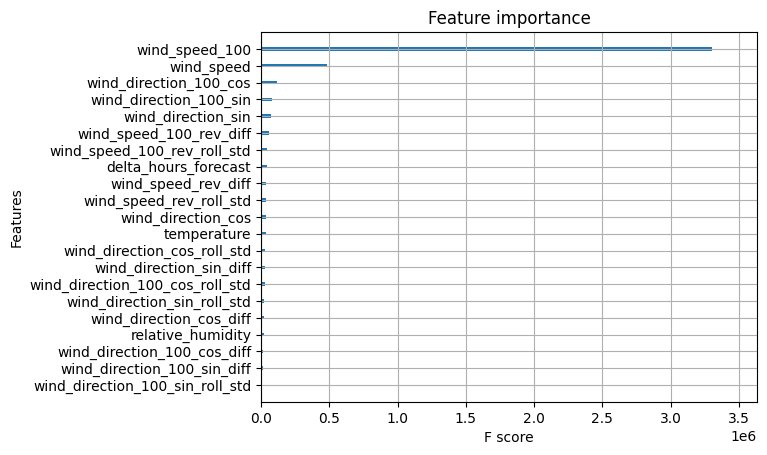

In [244]:
# get feature importance 
xgb.plot_importance(xgbr, importance_type='gain', show_values=False)
plt.show()

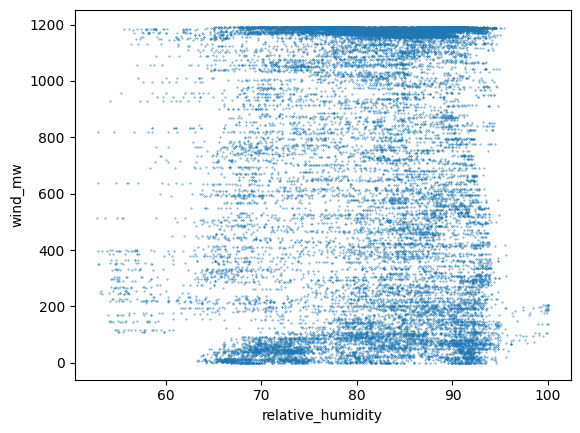

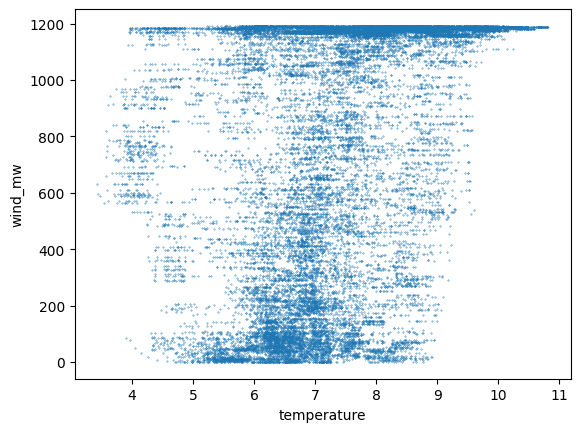

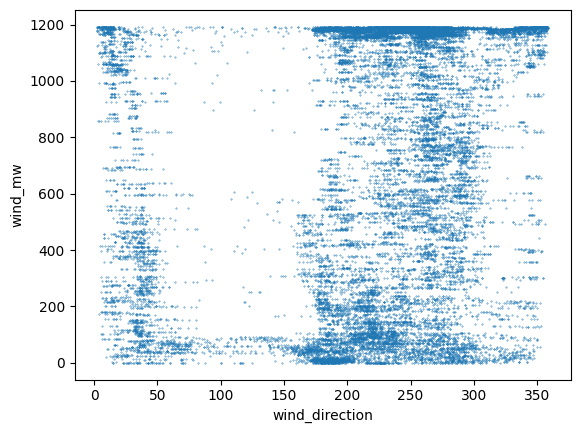

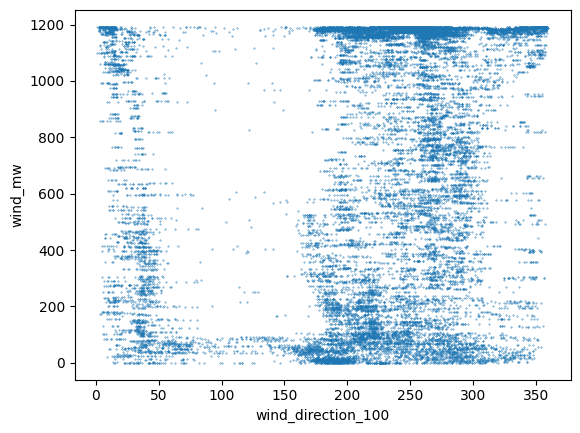

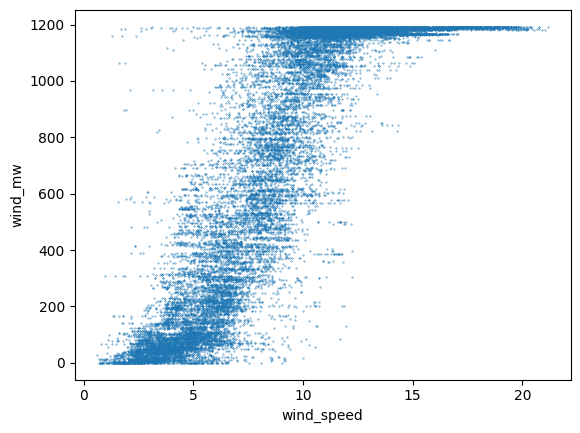

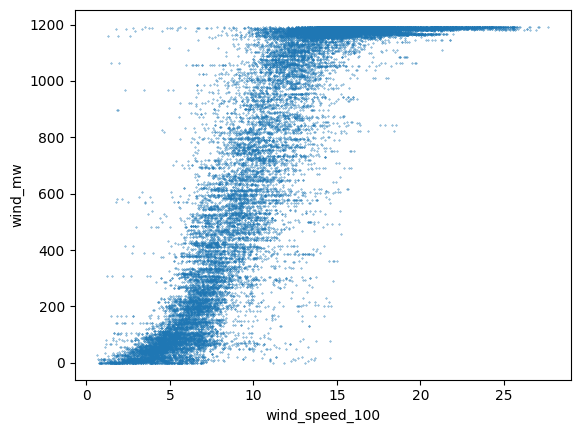

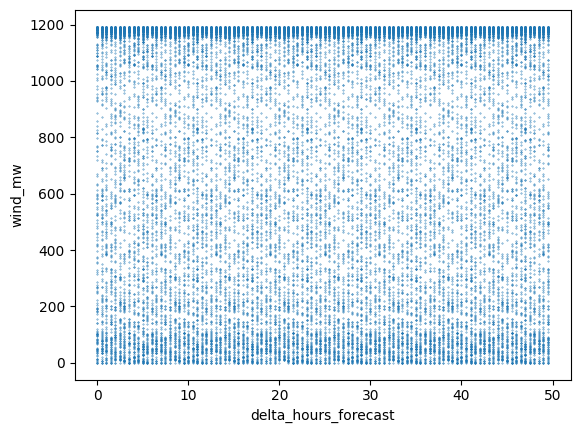

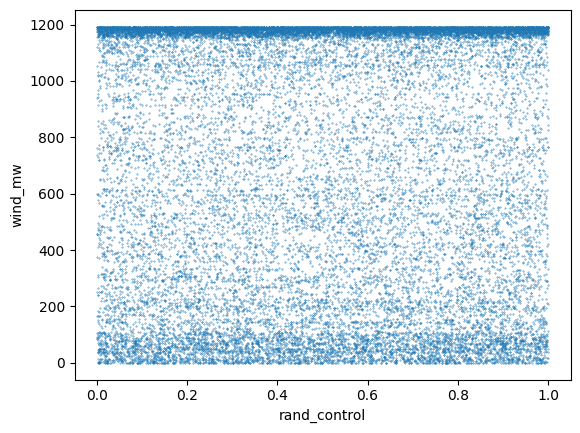

In [23]:
for f in features:
    plt.scatter(X_train[f], X_train.wind_mw, s=.1)
    plt.xlabel(f)
    plt.ylabel('wind_mw')
    plt.show()

In [30]:
# get predictions and accuracy states on test set

X_test['preds'] = xgbr.predict(X_test[features])
X_test['error'] = X_test['preds'] - X_test['wind_mw']
X_test['abs_error'] = np.abs(X_test['error'])
# X_test['abs_perc_error'] = X_test['abs_error'] / X_test['wind_mw']

X_test['error'].describe()
# X_test['abs_perc_error'].describe()


/tmp/ipykernel_18103/291545313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['preds'] = xgbr.predict(X_test[features])
/tmp/ipykernel_18103/291545313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['error'] = X_test['preds'] - X_test['wind_mw']
/tmp/ipykernel_18103/291545313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

count    12656.000000
mean        58.958401
std        234.695396
min       -800.126555
25%        -64.632847
50%          7.265544
75%        153.644196
max       1262.992409
Name: error, dtype: float64

In [31]:
X_test['abs_error'].describe()


count    12656.000000
mean       161.330214
std        180.357428
min          0.000008
25%         32.706733
50%        101.027335
75%        219.483327
max       1262.992409
Name: abs_error, dtype: float64

In [54]:
t = df_modelling[df_modelling.valid_datetime == '2023-01-20 02:00:00+00:00']
t

,ref_datetime,valid_datetime,relative_humidity,temperature,wind_direction,wind_direction_100,wind_speed,wind_speed_100,dtm,mip,solar_mw,solar_capacity_mwp,solar_installedcapacity_mwp,wind_mw,ss_price,boa_mwh,da_price,wind_mwh_credit,solar_mwh_credit
812271,2023-01-18 06:00:00+00:00,2023-01-20 02:00:00+00:00,84.502594,5.983883,316.346222,316.702881,11.790969,13.550827,2023-01-20 02:00:00+00:00,128.66,0.0,2269.245017,2409.925937,896.984,110.1,0.0,129.2,448.492,0.0
812272,2023-01-18 12:00:00+00:00,2023-01-20 02:00:00+00:00,80.719635,6.297604,310.913849,311.422455,12.159074,14.177049,2023-01-20 02:00:00+00:00,128.66,0.0,2269.245017,2409.925937,896.984,110.1,0.0,129.2,448.492,0.0
812273,2023-01-18 18:00:00+00:00,2023-01-20 02:00:00+00:00,84.788422,5.876753,313.595245,314.019104,12.140336,13.944886,2023-01-20 02:00:00+00:00,128.66,0.0,2269.245017,2409.925937,896.984,110.1,0.0,129.2,448.492,0.0
812274,2023-01-19 00:00:00+00:00,2023-01-20 02:00:00+00:00,82.281059,5.816515,303.316101,303.793610,11.358900,12.997534,2023-01-20 02:00:00+00:00,128.66,0.0,2269.245017,2409.925937,896.984,110.1,0.0,129.2,448.492,0.0
812275,2023-01-19 06:00:00+00:00,2023-01-20 02:00:00+00:00,83.196922,5.777564,303.539825,303.937958,11.741934,13.481143,2023-01-20 02:00:00+00:00,128.66,0.0,2269.245017,2409.925937,896.984,110.1,0.0,129.2,448.492,0.0
812276,2023-01-19 12:00:00+00:00,2023-01-20 02:00:00+00:00,84.365128,5.809747,317.094147,317.410126,11.759354,13.452761,2023-01-20 02:00:00+00:00,128.66,0.0,2269.245017,2409.925937,896.984,110.1,0.0,129.2,448.492,0.0
812277,2023-01-19 18:00:00+00:00,2023-01-20 02:00:00+00:00,84.340958,5.827559,314.878113,315.362183,11.831515,13.618652,2023-01-20 02:00:00+00:00,128.66,0.0,2269.245017,2409.925937,896.984,110.1,0.0,129.2,448.492,0.0
812278,2023-01-20 00:00:00+00:00,2023-01-20 02:00:00+00:00,88.525604,5.389401,309.417358,309.790131,11.842521,13.521309,2023-01-20 02:00:00+00:00,128.66,0.0,2269.245017,2409.925937,896.984,110.1,0.0,129.2,448.492,0.0


In [55]:
(t.valid_datetime - t.ref_datetime) / np.timedelta64(1, 'h')

812271    44.0
812272    38.0
812273    32.0
812274    26.0
812275    20.0
812276    14.0
812277     8.0
812278     2.0
dtype: float64

In [44]:
df_modelling.valid_datetime

0         2020-09-20 00:00:00+00:00
1         2020-09-20 00:30:00+00:00
2         2020-09-20 01:00:00+00:00
3         2020-09-20 01:30:00+00:00
4         2020-09-20 02:00:00+00:00
                     ...           
1020289   2023-08-19 23:00:00+00:00
1020290   2023-08-19 23:00:00+00:00
1020291   2023-08-19 23:00:00+00:00
1020292   2023-08-19 23:00:00+00:00
1020293   2023-08-19 23:00:00+00:00
Name: valid_datetime, Length: 423768, dtype: datetime64[ns, UTC]